# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [28]:
from matplotlib import widgets
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import io
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout

### Create a dataset

Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Unzip dataset

In [4]:
!unzip -q drive/MyDrive/archive.zip

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

80 - 20 split

In [6]:
data_dir = "Drug Vision/Data Combined"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


Verify classes

In [8]:
class_names = train_ds.class_names
print(class_names)

['Alaxan', 'Bactidol', 'Bioflu', 'Biogesic', 'DayZinc', 'Decolgen', 'Fish Oil', 'Kremil S', 'Medicol', 'Neozep']


## Visualize the data

Here are the first nine images from the training dataset:

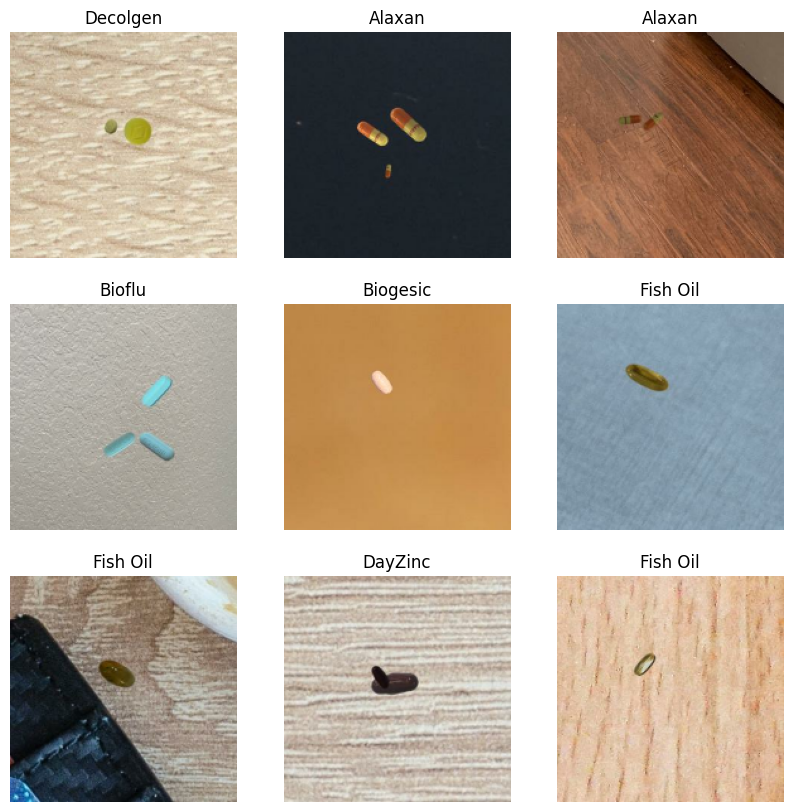

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Autotune chache and prefetch

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

Rescale RGB into 1


In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9294118


## A basic Keras model


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile Model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
250/250 [==============================] - 20s 30ms/step - loss: 2.1822 - accuracy: 0.1760 - val_loss: 2.0204 - val_accuracy: 0.2410
Epoch 2/10
250/250 [==============================] - 5s 21ms/step - loss: 1.8351 - accuracy: 0.3164 - val_loss: 1.7180 - val_accuracy: 0.3640
Epoch 3/10
250/250 [==============================] - 5s 20ms/step - loss: 1.2701 - accuracy: 0.5379 - val_loss: 1.2480 - val_accuracy: 0.5475
Epoch 4/10
250/250 [==============================] - 5s 21ms/step - loss: 0.7925 - accuracy: 0.7347 - val_loss: 1.0405 - val_accuracy: 0.6690
Epoch 5/10
250/250 [==============================] - 5s 20ms/step - loss: 0.4596 - accuracy: 0.8500 - val_loss: 1.0102 - val_accuracy: 0.7040
Epoch 6/10
250/250 [==============================] - 5s 21ms/step - loss: 0.2620 - accuracy: 0.9202 - val_loss: 1.1472 - val_accuracy: 0.7285
Epoch 7/10
250/250 [==============================] - 5s 20ms/step - loss: 0.1603 - accuracy: 0.9490 - val_loss: 1.3731 - val_accuracy: 0.710

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

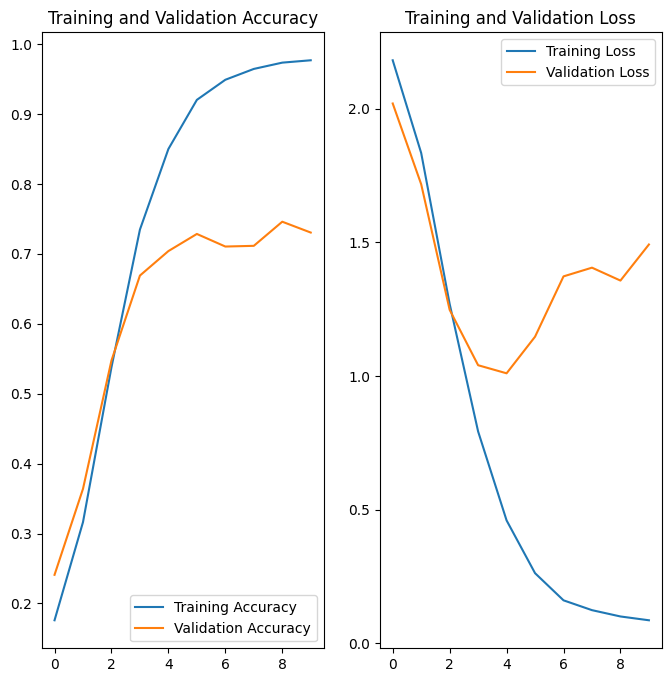

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting Prevention


## Data augmentation

Data argumentation by changing orietation 

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

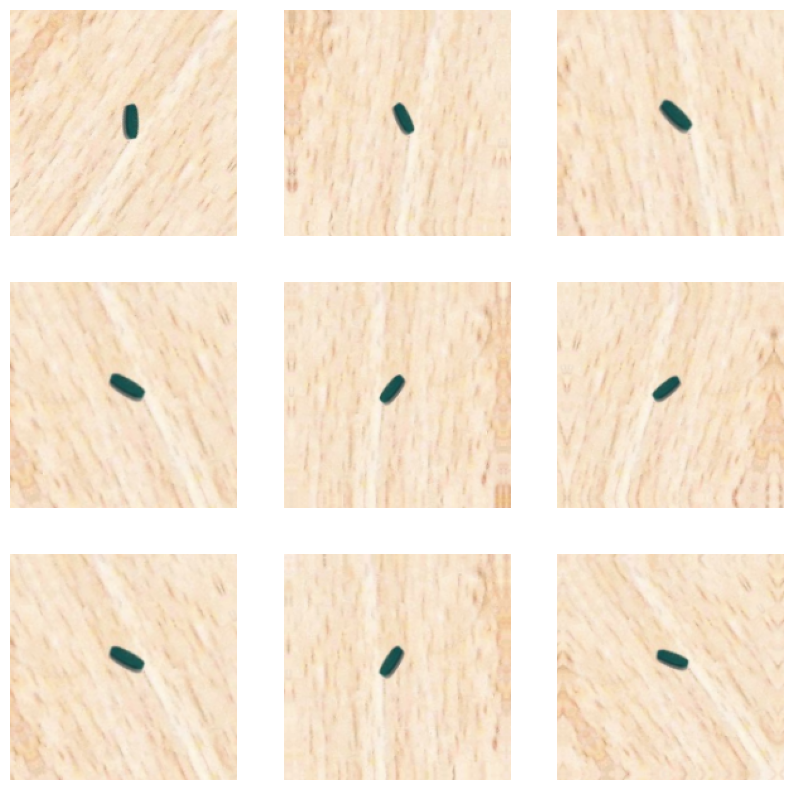

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout
Adding Dropout

In [41]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.9),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
250/250 [==============================] - 10s 30ms/step - loss: 2.2754 - accuracy: 0.1480 - val_loss: 2.0507 - val_accuracy: 0.2650
Epoch 2/20
250/250 [==============================] - 7s 30ms/step - loss: 1.8715 - accuracy: 0.3096 - val_loss: 1.5234 - val_accuracy: 0.4250
Epoch 3/20
250/250 [==============================] - 7s 28ms/step - loss: 1.5087 - accuracy: 0.4176 - val_loss: 1.2689 - val_accuracy: 0.5040
Epoch 4/20
250/250 [==============================] - 7s 29ms/step - loss: 1.3072 - accuracy: 0.4720 - val_loss: 1.1255 - val_accuracy: 0.5315
Epoch 5/20
250/250 [==============================] - 7s 29ms/step - loss: 1.1633 - accuracy: 0.5401 - val_loss: 0.9794 - val_accuracy: 0.6720
Epoch 6/20
250/250 [==============================] - 7s 28ms/step - loss: 1.0457 - accuracy: 0.6304 - val_loss: 0.8484 - val_accuracy: 0.7375
Epoch 7/20
250/250 [==============================] - 7s 29ms/step - loss: 0.8574 - accuracy: 0.7026 - val_loss: 0.6311 - val_accuracy: 0.807

Visualise

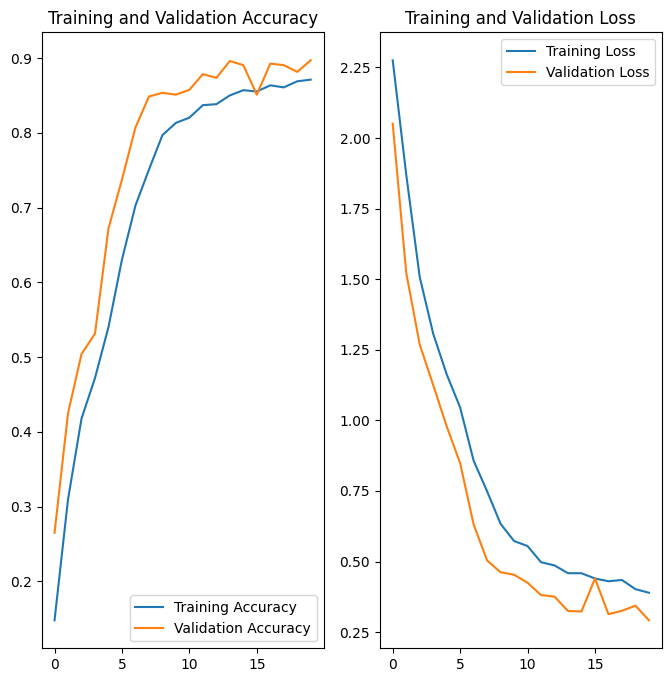

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Predictions

In [33]:

def predict(pill_path):
  # pill_path = "drive/MyDrive/neozep.jpg"

  img = tf.keras.utils.load_img(
      pill_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This pill is most likely {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

In [45]:
model.save('model2.h5')
tf.keras.models.load_model('model2.h5').summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#Implementation


Button(description='Check', icon='check', style=ButtonStyle(), tooltip='Description')

FileUpload(value={}, accept='.jpg', description='Upload')

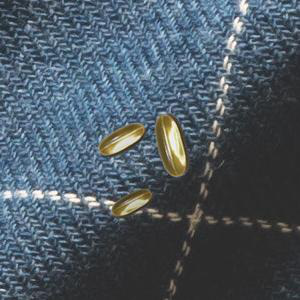

1/1 [==============================] - 0s 117ms/step
This image most likely belongs to Fish Oil with a 100.00 percent confidence.


In [46]:
text = widgets.HTML(
    value="<h1>Pill Checker </h1>",
)

uploaded_file = widgets.FileUpload(
    accept='.jpg',  
    multiple=False 
)


button = widgets.Button(
    description='Check',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)
display(button,uploaded_file)
def on_button_clicked(b): 
    #reading data from uploaded_file
    uploaded_filename = list(uploaded_file.value.keys())[0]
    uploaded_data = uploaded_file.value[uploaded_filename]['content']
    # Save the uploaded image
    with open(uploaded_filename, 'wb') as f:
        f.write(uploaded_data)
    #display image
    im = Image.open(f"{uploaded_filename}")
    im.show()
    #Run prediction
    predict(uploaded_filename)
button.on_click(on_button_clicked)
